#Final Project w266: Toxicity Detection


> ### Jake Pistotnik & Vijay Rangantha
  







##Installs

In [ ]:
#Installs
!pip install pydot --quiet
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install transformers --quiet
!pip install datasets 
!pip3 install emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 31.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.5 MB/s eta 0:00:00
Lo

##Imports


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from transformers import BertTokenizer, TFBertModel, AutoModel, AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModel, RobertaTokenizer

import nltk
from nltk.corpus import reuters
from nltk.data import find
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import TweetTokenizer

import sklearn as sk
import os

import matplotlib.pyplot as plt

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns

##DataSet Import

In [ ]:
import datasets 
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
df = dataset['train'].to_pandas()

##Citation
##@article{kennedy2020constructing,
  #title={Constructing interval variables via faceted Rasch measurement and multitask deep learning: a hate speech application},
  #author={Kennedy, Chris J and Bacon, Geoff and Sahn, Alexander and von Vacano, Claudia},
  #journal={arXiv preprint arXiv:2009.10277},
  #year={2020}
#}

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/ucberkeley-dlab___parquet/ucberkeley-dlab--measuring-hate-speech-c32713cabe528196/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# list of all the columns in the dataframe
for i in df.columns:
  print(i)

comment_id
annotator_id
platform
sentiment
respect
insult
humiliate
status
dehumanize
violence
genocide
attack_defend
hatespeech
hate_speech_score
text
infitms
outfitms
annotator_severity
std_err
annotator_infitms
annotator_outfitms
hypothesis
target_race_asian
target_race_black
target_race_latinx
target_race_middle_eastern
target_race_native_american
target_race_pacific_islander
target_race_white
target_race_other
target_race
target_religion_atheist
target_religion_buddhist
target_religion_christian
target_religion_hindu
target_religion_jewish
target_religion_mormon
target_religion_muslim
target_religion_other
target_religion
target_origin_immigrant
target_origin_migrant_worker
target_origin_specific_country
target_origin_undocumented
target_origin_other
target_origin
target_gender_men
target_gender_non_binary
target_gender_transgender_men
target_gender_transgender_unspecified
target_gender_transgender_women
target_gender_women
target_gender_other
target_gender
target_sexuality_bisexu

In [ ]:
# creating arrays of text column and labels column for viewing and making text columns str
df['text'].astype(str)
df = df[['text', 'hate_speech_score']].groupby('text').mean().reset_index()
text = np.array(df['text'])
labels = np.array(df['hate_speech_score'])

##EDA

<Axes: ylabel='Count'>

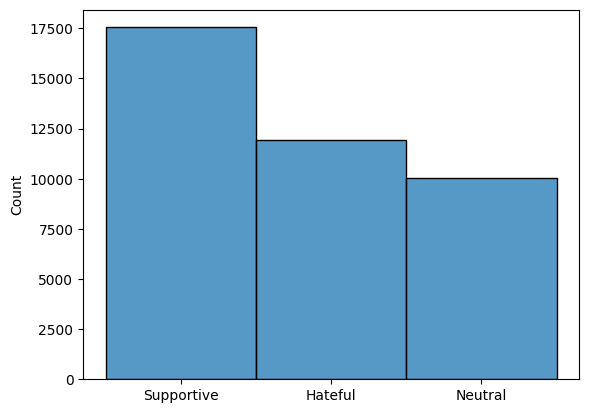

In [ ]:
##EDA
import seaborn as sns
def str_labler(arr):
  new_arr = []
  for i in arr:
    if i >= .3:
      new_arr.append("Hateful")
    elif i < .3 and i > -1:
      new_arr.append("Neutral")
    else:
      new_arr.append("Supportive")
  return new_arr
labels_str = str_labler(labels)
sns.histplot(labels_str)

In [ ]:
supp_count = len([i for i in labels_str if i =="Supportive"])
hate_count = len([i for i in labels_str if i =="Hateful"])
neut_count = len([i for i in labels_str if i =="Neutral"])
total_count = len(labels_str)
print("Supportive Count: ", supp_count)
print("Supportive Prop: ", supp_count/total_count)
print("Hateful Count: ", hate_count)
print("Hateful Prop: ", hate_count/total_count)
print("Neutral Count: ", neut_count)
print("Neutral Prop: ", neut_count/total_count)

Supportive Count:  17553
Supportive Prop:  0.4436496903829142
Hateful Count:  11954
Hateful Prop:  0.3021357260204726
Neutral Count:  10058
Neutral Prop:  0.25421458359661314


In [ ]:
supp_exs = df[df['hate_speech_score'] < -1].sort_values('hate_speech_score')
hate_exs = df[df['hate_speech_score'] > .3].sort_values('hate_speech_score', ascending = False)
neut_exs = df[df['hate_speech_score'].between(-1,.3)]
hate_neut_edge_exs = df[df['hate_speech_score'].between(.3,.6)]

In [ ]:
supp_exs

,text,hate_speech_score
11464,Fellow trans girl here! Love and support confi...,-8.34
29324,There's a church near where in live that used ...,-8.30
11687,For my brave girls all over the world defying ...,-8.28
24771,Pro wrestler Mercedes Martinez has been provin...,-8.24
27312,Such a huge and heartwarming thank you to over...,-8.21
...,...,...
22087,Minnesota...the Sweden of the United States. M...,-1.01
22995,Niggas listen to their boys too much. Girls do...,-1.01
38062,"rape is horrible, rapists are scum. the proble...",-1.01
19972,"It's not simply a label if it's true tho, you ...",-1.01


In [ ]:
hate_exs

,text,hate_speech_score
10421,Dig burn PITS and treat them THE INVADING NAZI...,6.30
36382,fr diva gays are the worst types of faggots. t...,6.09
20501,KILL THEM ALL PUT THEM HOES TO REST WALK IN BU...,6.05
16735,I wanna abuse that worthless whore ass for hours,6.01
23122,No fuck off. You are all lost causes and all o...,5.78
...,...,...
10907,Eat my pussy from the back bitch,0.31
18059,I'm sure your God is real proud there's a sexu...,0.31
11074,Europeans who are flooding their country with ...,0.31
16284,I only fuck bad bitches,0.31


In [ ]:
neut_exs[neut_exs['hate_speech_score'].between(-.01,.01)]

,text,hate_speech_score
18,""".. Soo what are you gonna pick love? ~"" 💬 to ...",-0.01
229,"""I'm not racist, ah jus think black people and...",0.01
297,"""Men who are too good looking are never good i...",-0.01
527,"""You'd die for her."" There is the answer, you ...",-0.01
925,'Slaughter the Jews' painted on section of Wes...,0.00
...,...,...
38195,she should choke on my penis :),0.01
38380,stop posting faggot,-0.01
38690,this bitch retarted URL,0.01
38899,ugly bitches talk the most shit like stfu,-0.01


In [ ]:
hate_neut_edge_exs.sort_values('hate_speech_score', ascending = True).loc[23592]['text']

'Number killed from car accidents: 1,000,000. Number killed by the word nigger: 0 Therefore, nigger is no big deal.'

##Pre-Processing

In [ ]:
def labler(arr):
  new_arr = []
  for i in arr:
    if i >= .3:
      new_arr.append(1)
    elif i < .3 and i > -1:
      new_arr.append(0)
    else:
      new_arr.append(2)
  return new_arr

In [ ]:
#https://www.educative.io/answers/remove-all-the-punctuation-marks-from-a-sentence-using-regex
def preprocesser(ex):
  clean_data = []
  for i in ex:
    i = i.lower()
    j = re.sub(r'@[A-Za-z]*\.?[A-Za-z0-9]*', "", i)
    j = re.sub(r"http\S+", "", j)
    j = re.sub(r"url\S+", "", j)
    j = re.sub(r"!flair", "", j)
    j = re.sub(r"\[", "", j)
    j = re.sub(r"\]", "", j)
    while '  ' in j:
      j = j.replace('  ', ' ')
    clean_data.append(j)
  return np.array(clean_data)

df

,text,hate_speech_score
0,! thank u! im transmasc and generally present ...,-3.92
1,!Go fuck yourself faggot!,2.47
2,!flair [I love women and minorities],-4.48
3,!flair [death to all niggers and gays],3.28
4,""" 'convoluted' genealogy of Jesus""; was that c...",-3.18
...,...,...
39560,🤧 The limousine liberal Jews and WASPs who wa...,1.99
39561,🤬CONGRATULATIONS #MARYLAND #BALTIMORE LIBERALS...,-0.51
39562,🥳 another bitch will when another bitch can't,0.51
39563,🥴🥴 next time stay your ass in the car before o...,-1.22


In [ ]:
#labels = labler(labels)
new_df = df.apply(lambda x: labler(x) if x.name == 'hate_speech_score' else x,
                axis = 0)
new_df = new_df.apply(lambda x: preprocesser(x) if x.name == 'text' else x,
                axis = 0)

In [ ]:
new_df['hate_speech_score'].value_counts()

2    17553
1    12730
0     9282
Name: hate_speech_score, dtype: int64

In [ ]:
new_df['2class_hate_speech'] = [0 if i in [0,2] else 1 for i in new_df['hate_speech_score'].values]

In [ ]:
new_df['2class_hate_speech'].value_counts()

0    26835
1    12730
Name: 2class_hate_speech, dtype: int64

In [ ]:
np.random.seed(6543)
grouped = new_df[['hate_speech_score', 'text', '2class_hate_speech']].groupby('hate_speech_score', as_index = False).apply(lambda x: x.sample(9000)).reset_index()
df = grouped[['hate_speech_score', 'text', '2class_hate_speech']]
df

,hate_speech_score,text,2class_hate_speech
0,0,their karma has caught up with them. the bite...,0
1,0,enjoy you're freedom this could be a muslim co...,0
2,0,imagine them existing they would be like 9/10 ...,0
3,0,we will do better than that we will prosecute...,0
4,0,if you gotta press a nigga to do simple shit l...,0
...,...,...,...
26995,2,no huge differences between us and the others ...,0
26996,2,find you a good general contractor he should h...,0
26997,2,"that's why that one came here, went through th...",0
26998,2,solid point. i was thinking about starting an ...,0


##Train/Test/Val Split

In [ ]:
np.random.seed(6543)
shuffle = np.random.permutation(np.arange(df.shape[0]))

train_data, val_data, test_data = df.iloc[shuffle][:round(len(df)*.7)], df.iloc[shuffle][round(len(df)*.7):round(len(df)*.85)], df.iloc[~shuffle][round(len(df)*.85):round(len(df))]

train_examples, train_labels = preprocesser(train_data['text']), np.array(train_data['hate_speech_score'])
val_examples, val_labels = preprocesser(val_data['text']), np.array(val_data['hate_speech_score'])
test_examples, test_labels = preprocesser(test_data['text']), np.array(test_data['hate_speech_score'])
binary_train_examples, binary_train_labels = preprocesser(train_data['text']), np.array(train_data['2class_hate_speech'])
binary_val_examples, binary_val_labels = preprocesser(val_data['text']), np.array(val_data['2class_hate_speech'])
binary_test_examples, binary_test_labels = preprocesser(test_data['text']), np.array(test_data['2class_hate_speech'])

In [ ]:
train_data['2class_hate_speech'].value_counts()

0    12554
1     6346
Name: 2class_hate_speech, dtype: int64

In [ ]:
print(len(train_examples) == len(train_labels))
print(len(val_examples) == len(val_labels))
print(len(test_examples) == len(test_labels))

True
True
True


In [ ]:
print(train_labels[:10])
print(train_data['hate_speech_score'][:10].values)

[0 2 0 0 2 0 1 0 2 1]
[0 2 0 0 2 0 1 0 2 1]


In [ ]:
val_data['hate_speech_score'].value_counts()

0    1378
2    1347
1    1325
Name: hate_speech_score, dtype: int64

<Axes: xlabel='hate_speech_score', ylabel='text'>

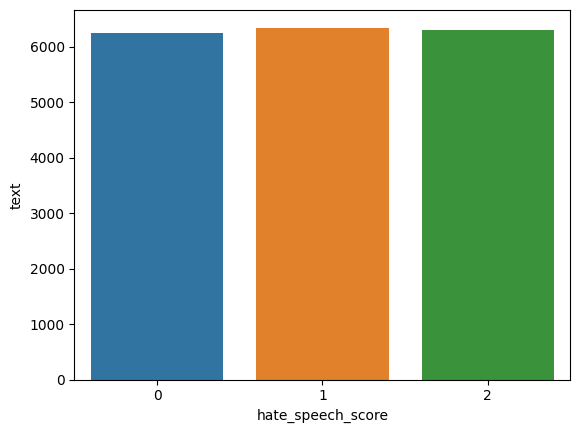

In [ ]:
labels1 = train_data.groupby('hate_speech_score').agg('count')
sns.barplot(x = labels1.index, y = labels1['text'])

##Regular Tokenization

In [ ]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
val_tokens = tokenizer.tokenize(val_examples)
test_tokens = tokenizer.tokenize(test_examples)

In [ ]:
max([len(i) for i in train_tokens.numpy()])

128

In [ ]:
np.mean([len(i) for i in train_tokens.numpy()])

24.330529100529102

In [ ]:
np.median([len(i) for i in train_tokens.numpy()])

19.0

## Baseline

In [ ]:
def baseline_model(lbls):
  guesses = []
  for i in range(len(lbls)):
    x = np.random.uniform(low=0, high=1)
    if x <= supp_count/total_count:
      guesses.append(2)
    elif x <= (supp_count + hate_count)/total_count and x > supp_count/total_count:
      guesses.append(1)
    elif x > (supp_count + hate_count)/total_count and x<=1:
      guesses.append(0)
  return guesses

In [ ]:
baseline_guesses = baseline_model(test_labels)

In [ ]:
baseline_accuracy = np.mean([1 if baseline_guesses[i] == test_labels[i] else 0 for i in range(len(test_labels))])
baseline_accuracy

0.34617283950617284

In [ ]:
print(classification_report(test_labels, baseline_guesses))

              precision    recall  f1-score   support

           0       0.36      0.25      0.29      1343
           1       0.33      0.32      0.33      1329
           2       0.35      0.46      0.40      1378

    accuracy                           0.35      4050
   macro avg       0.35      0.35      0.34      4050
weighted avg       0.35      0.35      0.34      4050



In [ ]:
cm = tf.math.confusion_matrix(test_labels, baseline_guesses)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

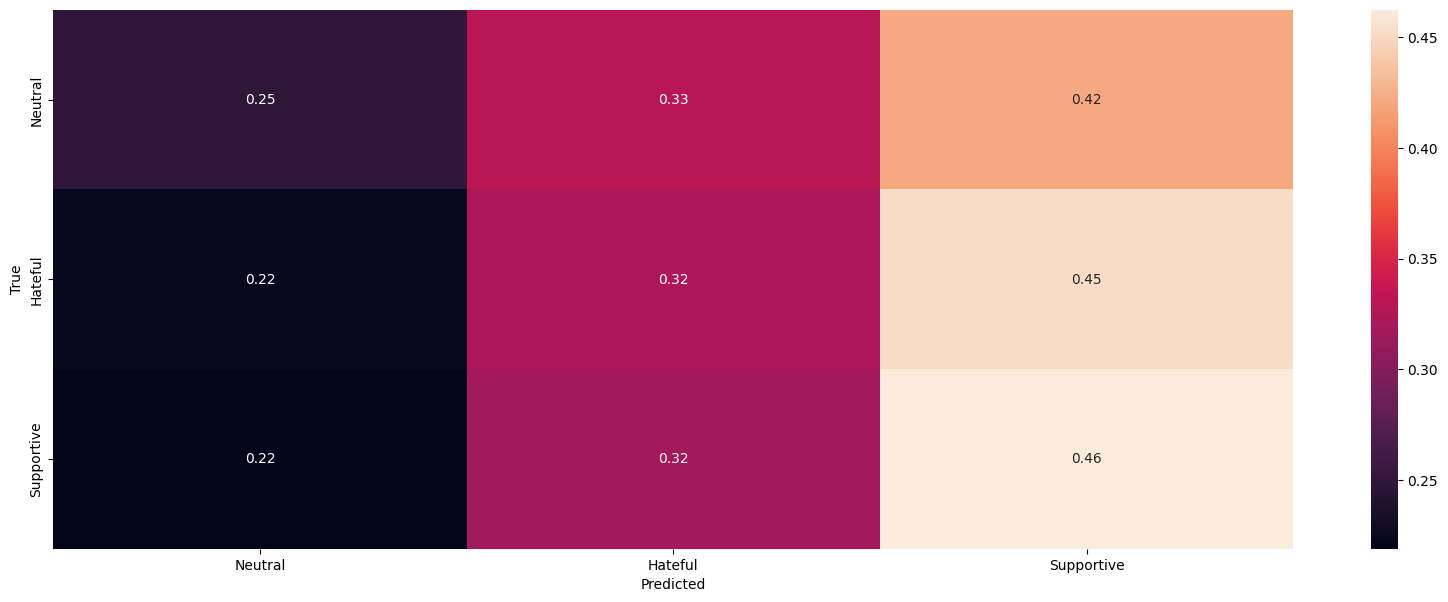

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Neutral", "Hateful", "Supportive"],
    yticklabels=["Neutral", "Hateful", "Supportive"])
plt.xlabel("Predicted")
plt.ylabel("True")

## Bert Tokenization


In [ ]:
#Train and Test for Bert Based Models
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

MAX_SEQUENCE_LENGTH = 128

bert_train_tokenized = bert_tokenizer(list(train_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
                     bert_train_tokenized.token_type_ids,
                     bert_train_tokenized.attention_mask]
bert_train_labels = np.array(train_labels)

bert_val_tokenized = bert_tokenizer(list(val_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_val_inputs = [bert_val_tokenized.input_ids,
                     bert_val_tokenized.token_type_ids,
                     bert_val_tokenized.attention_mask]
bert_val_labels = np.array(val_labels)

bert_test_tokenized = bert_tokenizer(list(test_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_test_inputs = [bert_test_tokenized.input_ids,
                     bert_test_tokenized.token_type_ids,
                     bert_test_tokenized.attention_mask]
bert_test_labels = np.array(test_labels)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
#max(len(x) for x in bert_train_inputs)
np.unique(bert_train_labels[:5000], return_counts =True)

(array([0, 1, 2]), array([1619, 1719, 1662]))

##BERT CLS

In [ ]:
#BERT Base Case
def create_bert_cls_classification_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          dropout = 0.3,
                          hidden_size = 100, 
                          learning_rate=0.00001):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """


    bert_model.trainable = True
    max_length = MAX_SEQUENCE_LENGTH
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer', kernel_regularizer='l1')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [ ]:
bert_cls_classification_model = create_bert_cls_classification_model()
bert_cls_classification_model.summary()
#confirm all layers are frozen
bert_cls_classification_model_history = bert_cls_classification_model.fit(
    [bert_train_inputs[0], bert_train_inputs[1], bert_train_inputs[2]],
    bert_train_labels,
    validation_data=([bert_val_inputs[0], bert_val_inputs[1], bert_val_inputs[2]], bert_val_labels),
    batch_size=8,
    epochs=4)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

2363/2363 [==============================] - 611s 252ms/step - loss: 0.6533 - accuracy: 0.8863 - val_loss: 1.5845 - val_accuracy: 0.6202
Epoch 2/4
2363/2363 [==============================] - 591s 250ms/step - loss: 0.5181 - accuracy: 0.9320 - val_loss: 1.7323 - val_accuracy: 0.6131
Epoch 3/4
2363/2363 [==============================] - 588s 249ms/step - loss: 0.4496 - accuracy: 0.9482 - val_loss: 2.0086 - val_accuracy: 0.6180
Epoch 4/4
2363/2363 [==============================] - 589s 249ms/step - loss: 0.3960 - accuracy: 0.9585 - val_loss: 2.0329 - val_accuracy: 0.6069


In [ ]:
cls_predictions = bert_cls_classification_model.predict([bert_test_inputs[0], bert_test_inputs[1], bert_test_inputs[2]])
cls_predictions = tf.argmax(cls_predictions, axis=-1)

In [ ]:
print(classification_report(bert_test_labels, cls_predictions))#, target_names=["Neutral", "Hateful", "Supportive"]))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1343
           1       0.88      0.88      0.88      1329
           2       0.92      0.87      0.89      1378

    accuracy                           0.86      4050
   macro avg       0.86      0.86      0.86      4050
weighted avg       0.86      0.86      0.86      4050



Text(220.72222222222223, 0.5, 'True')

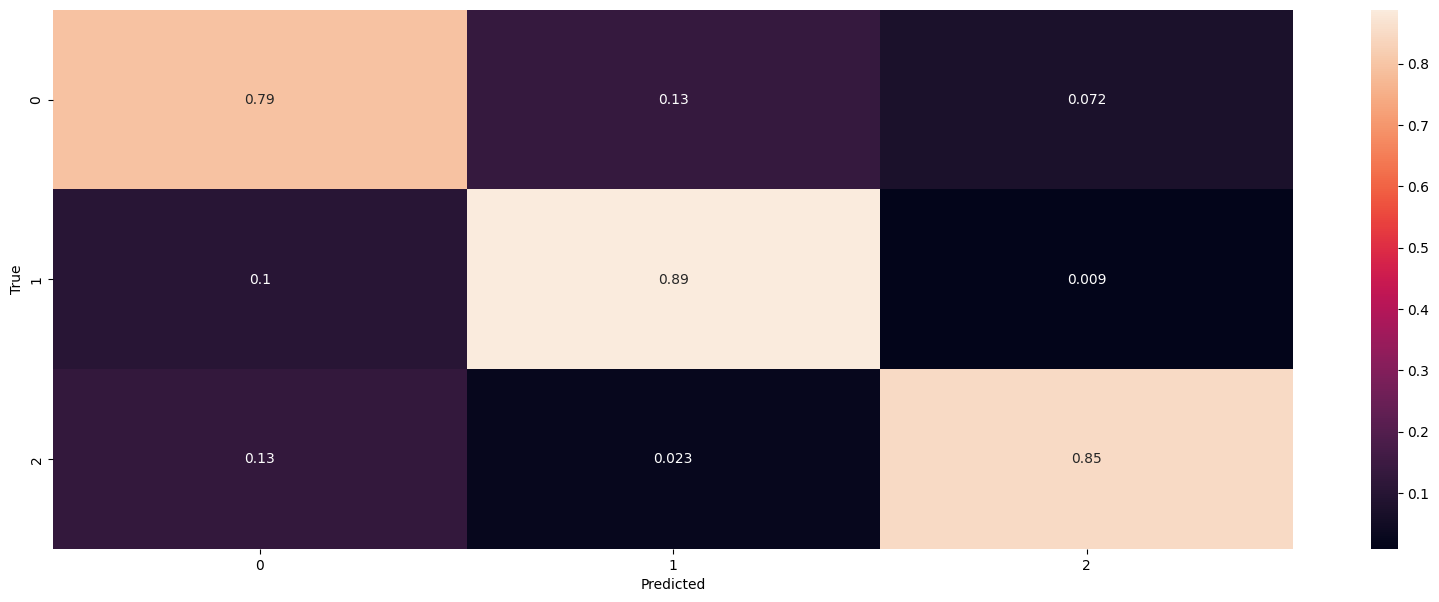

In [ ]:
cm = tf.math.confusion_matrix(bert_test_labels, cls_predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

##Bert CNN

In [ ]:
def create_bert_cnn_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          num_filters = [100, 100, 50, 25],
                          kernel_sizes = [2, 3, 4, 5],
                          dropout = 0.3,
                          hidden_size = 100, 
                          learning_rate=0.00001):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """


    bert_model.trainable = True
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)[0]
  
    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(bert_out)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

    dropout = keras.layers.Dropout(rate=dropout)(conv_output)

    hidden_output = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(dropout)

    classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer', kernel_regularizer='l1')(hidden_output)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                                 metrics='accuracy')

    
    return classification_model

In [ ]:
bert_cnn_model = create_bert_cnn_model()
bert_cnn_model.summary()
#confirm all layers are frozen
bert_cnn_model_history = bert_cnn_model.fit(
    [bert_train_inputs[0], bert_train_inputs[1], bert_train_inputs[2]],
    bert_train_labels,
    validation_data=([bert_val_inputs[0], bert_val_inputs[1], bert_val_inputs[2]], bert_val_labels),
    batch_size=8,
    epochs=5)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

2363/2363 [==============================] - 651s 264ms/step - loss: 0.6016 - accuracy: 0.9124 - val_loss: 0.8539 - val_accuracy: 0.8454
Epoch 2/5
2363/2363 [==============================] - 622s 263ms/step - loss: 0.5059 - accuracy: 0.9383 - val_loss: 0.8145 - val_accuracy: 0.8526
Epoch 3/5
2363/2363 [==============================] - 619s 262ms/step - loss: 0.4492 - accuracy: 0.9498 - val_loss: 0.7714 - val_accuracy: 0.8563
Epoch 4/5
2363/2363 [==============================] - 619s 262ms/step - loss: 0.3902 - accuracy: 0.9630 - val_loss: 0.8062 - val_accuracy: 0.8612
Epoch 5/5
2363/2363 [==============================] - 618s 262ms/step - loss: 0.3595 - accuracy: 0.9658 - val_loss: 0.8310 - val_accuracy: 0.8585


In [ ]:
np.unique(bert_train_labels, return_counts = True)

(array([0, 1, 2]), array([6244, 6346, 6310]))

In [ ]:
cnn_predictions = bert_cnn_model.predict([bert_test_inputs[0], bert_test_inputs[1], bert_test_inputs[2]])
cnn_predictions = tf.argmax(cnn_predictions, axis=-1)

In [ ]:
print(classification_report(bert_test_labels, cnn_predictions))#, target_names=["Neutral", "Hateful", "Supportive"]))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1343
           1       0.92      0.85      0.88      1329
           2       0.89      0.88      0.89      1378

    accuracy                           0.86      4050
   macro avg       0.86      0.86      0.86      4050
weighted avg       0.86      0.86      0.86      4050



Text(220.72222222222223, 0.5, 'True')

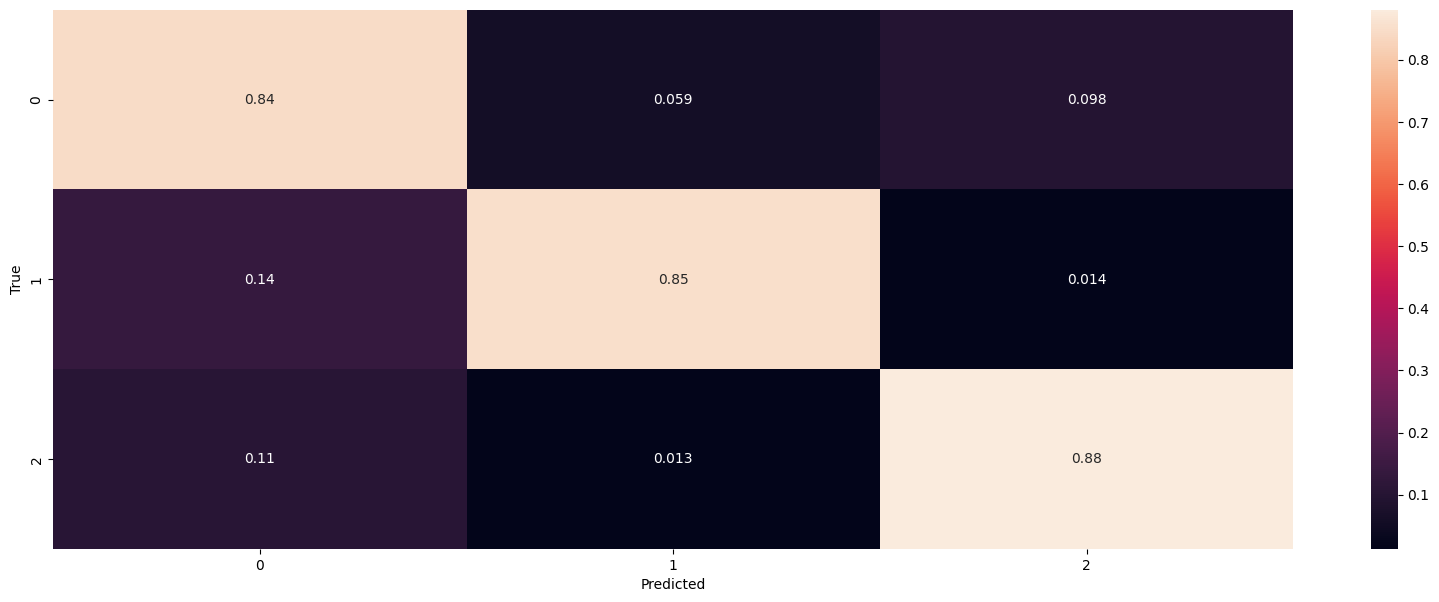

In [ ]:
cm = tf.math.confusion_matrix(bert_test_labels, cnn_predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

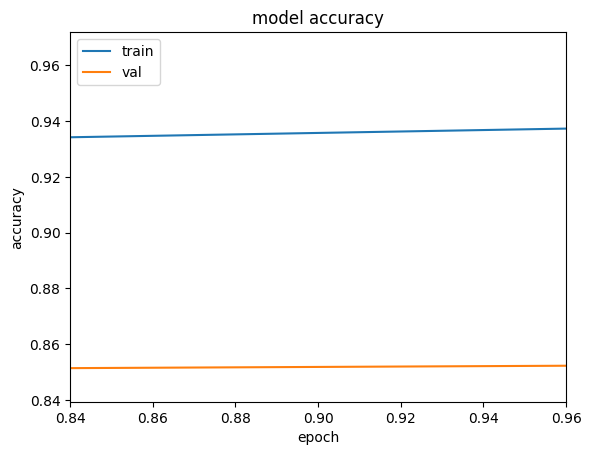

In [ ]:
from matplotlib import pyplot as plt
plt.plot(bert_cnn_model_history.history['accuracy'])
plt.plot(bert_cnn_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xlim(.84, .96)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##Roberta

In [ ]:
from transformers import RobertaConfig, TFRobertaModel

In [ ]:
#Roberta Model, Tokenizer, and Train and Test Sets

roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base")

MAX_SEQUENCE_LENGTH = 128
roberta_train_tokenized = roberta_tokenizer(list(train_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              add_special_tokens=True,
              return_tensors='tf')
print(roberta_train_tokenized)
roberta_train_inputs = [roberta_train_tokenized.input_ids,
                     roberta_train_tokenized.attention_mask]
roberta_train_labels = np.array(train_labels)

roberta_val_tokenized = roberta_tokenizer(list(val_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
roberta_val_inputs = [roberta_val_tokenized.input_ids,
                     roberta_val_tokenized.attention_mask]
roberta_val_labels = np.array(val_labels)

roberta_test_tokenized = roberta_tokenizer(list(test_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
roberta_test_inputs = [roberta_test_tokenized.input_ids,
                     #roberta_test_tokenized.token_type_ids,
                     roberta_test_tokenized.attention_mask]
roberta_test_labels = np.array(test_labels)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


{'input_ids': <tf.Tensor: shape=(18900, 128), dtype=int32, numpy=
array([[    0, 18636,  8384, ...,     1,     1,     1],
       [    0,  3226, 43675, ...,     1,     1,     1],
       [    0, 14746,    40, ...,     1,     1,     1],
       ...,
       [    0,  5016,    47, ...,     1,     1,     1],
       [    0,   282,  3938, ...,     1,     1,     1],
       [    0, 22466,   213, ...,     1,     1,     1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(18900, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


In [ ]:
def create_roberta_classification_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          num_filters = [100, 100, 50, 25],
                          kernel_sizes = [2, 3, 4, 5],
                          dropout = 0.3,
                          hidden_size = 100, 
                          learning_rate=.00001):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """


    roberta_model.trainable = True
    #max_length = 100
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
   # token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    roberta_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}      

    roberta_out = roberta_model(roberta_inputs)

    pooler_token = roberta_out[1]
    print(pooler_token)
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer', kernel_regularizer='l1')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [ ]:
roberta_classification_model = create_roberta_classification_model()
roberta_classification_model.summary()
#confirm all layers are frozen
roberta_classification_model_history = roberta_classification_model.fit(
    [roberta_train_inputs[0], roberta_train_inputs[1]],
    roberta_train_labels,
    validation_data=([roberta_val_inputs[0], roberta_val_inputs[1]], roberta_val_labels),
    batch_size=8,
    epochs=2)

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_roberta_model/roberta/pooler/dense/Tanh:0', description="created by layer 'tf_roberta_model'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['attention_mask_layer[0][0]',   
 el) 

In [ ]:
learning_rates = [0.00005, .0005, .005]
Max_lengths = [64, 128, 160]
lrs = {0.0001: }


LR @ 0.0001: train acc = .6653, val acc = .6880
LR @ .00005: 
```
# This is formatted as code
```



In [ ]:
from sklearn.metrics import classification_report

In [ ]:
predictions = roberta_classification_model.predict([roberta_test_inputs[0], roberta_test_inputs[1]])

In [ ]:
predictions = tf.argmax(predictions, axis=-1)

In [ ]:
print(classification_report(roberta_test_labels, predictions))#, target_names=["Neutral", "Hateful", "Supportive"]))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1343
           1       0.91      0.85      0.88      1329
           2       0.89      0.89      0.89      1378

    accuracy                           0.85      4050
   macro avg       0.85      0.85      0.85      4050
weighted avg       0.85      0.85      0.85      4050



In [ ]:
np.unique(np.array(predictions))

array([1])

In [ ]:
cm = tf.math.confusion_matrix(roberta_test_labels, predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

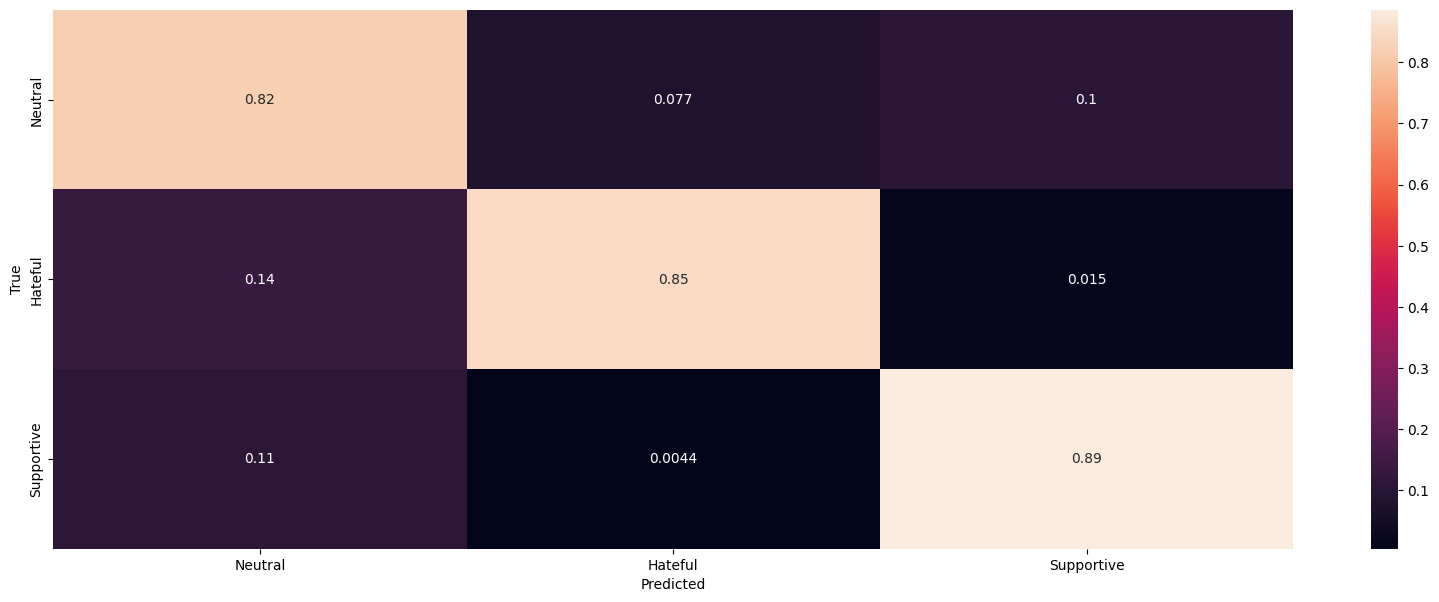

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Neutral", "Hateful", "Supportive"],
    yticklabels=["Neutral", "Hateful", "Supportive"])
plt.xlabel("Predicted")
plt.ylabel("True")

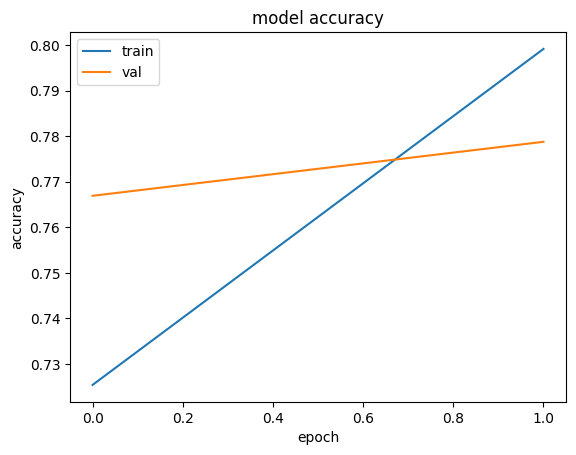

In [ ]:
from matplotlib import pyplot as plt
history = roberta_classification_model.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(roberta_classification_model_history.history['accuracy'])
plt.plot(roberta_classification_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Roberta Multiclass, Binary, and Combined


In [ ]:
from transformers import RobertaConfig, TFRobertaModel

In [ ]:
#Roberta Model, Tokenizer, and Train and Test Sets

roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base")

MAX_SEQUENCE_LENGTH = 128
roberta_train_tokenized = roberta_tokenizer(list(train_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              add_special_tokens=True,
              return_tensors='tf')
print(roberta_train_tokenized)
roberta_train_inputs = [roberta_train_tokenized.input_ids,
                     roberta_train_tokenized.attention_mask]
roberta_train_labels = np.array(train_labels)

roberta_val_tokenized = roberta_tokenizer(list(val_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
roberta_val_inputs = [roberta_val_tokenized.input_ids,
                     roberta_val_tokenized.attention_mask]
roberta_val_labels = np.array(val_labels)

roberta_test_tokenized = roberta_tokenizer(list(test_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
roberta_test_inputs = [roberta_test_tokenized.input_ids,
                     #roberta_test_tokenized.token_type_ids,
                     roberta_test_tokenized.attention_mask]
roberta_test_labels = np.array(test_labels)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


{'input_ids': <tf.Tensor: shape=(18900, 128), dtype=int32, numpy=
array([[    0, 24916,   324, ...,     1,     1,     1],
       [    0,   118,   657, ...,     1,     1,     1],
       [    0,  1694,  1595, ...,     1,     1,     1],
       ...,
       [    0,   113,   428, ...,     1,     1,     1],
       [    0, 38060,   197, ...,     1,     1,     1],
       [    0,  3999,   102, ...,     1,     1,     1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(18900, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


In [ ]:
def create_roberta1_classification_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          num_filters = [100, 100, 50, 25],
                          kernel_sizes = [2, 3, 4, 5],
                          dropout = 0.3,
                          hidden_size = 100, 
                          learning_rate=.00001):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """


    roberta_model.trainable = True
    #max_length = 100
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
   # token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    roberta_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}      

    roberta_out = roberta_model(roberta_inputs)

    pooler_token = roberta_out[1]
    print(pooler_token)
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer',kernel_regularizer='l1' )(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [ ]:
roberta1_classification_model = create_roberta1_classification_model()
roberta1_classification_model.summary()
#confirm all layers are frozen
roberta1_classification_model_history = roberta1_classification_model.fit(
    [roberta_train_inputs[0], roberta_train_inputs[1]],
    roberta_train_labels,
    validation_data=([roberta_val_inputs[0], roberta_val_inputs[1]], roberta_val_labels),
    batch_size=8,
    epochs=8)

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_roberta_model/roberta/pooler/dense/Tanh:0', description="created by layer 'tf_roberta_model'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['attention_mask_layer[0][0]',   
 el)   

In [ ]:
predictions1 = roberta1_classification_model.predict([roberta_test_inputs[0], roberta_test_inputs[1]])

In [ ]:
predictions1 = tf.argmax(predictions1, axis=-1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(roberta_test_labels, predictions1))#, target_names=["Neutral", "Hateful", "Supportive"]))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1343
           1       0.87      0.89      0.88      1329
           2       0.89      0.90      0.90      1378

    accuracy                           0.86      4050
   macro avg       0.86      0.86      0.86      4050
weighted avg       0.86      0.86      0.86      4050



In [ ]:
cm = tf.math.confusion_matrix(roberta_test_labels, predictions1)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

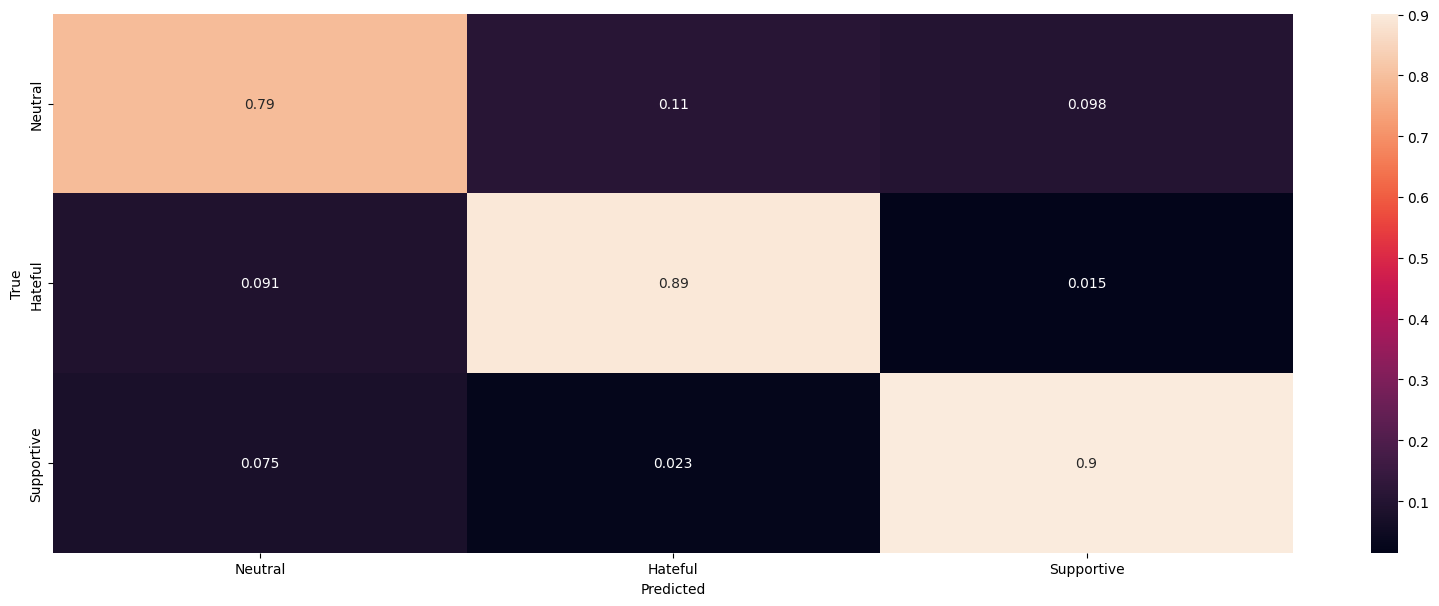

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Neutral", "Hateful", "Supportive"],
    yticklabels=["Neutral", "Hateful", "Supportive"])
plt.xlabel("Predicted")
plt.ylabel("True")

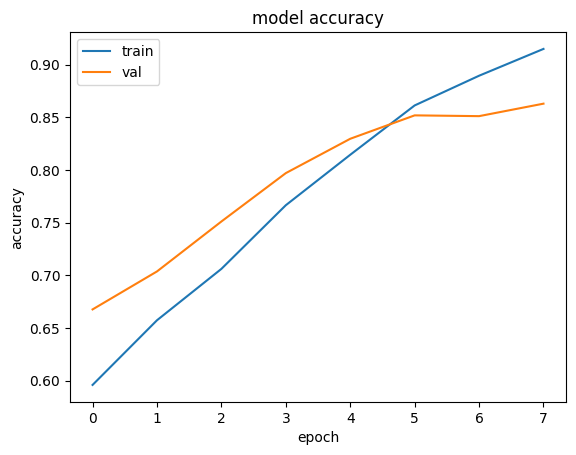

In [ ]:
from matplotlib import pyplot as plt
plt.plot(roberta1_classification_model_history.history['accuracy'])
plt.plot(roberta1_classification_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
incorrects_roberta = []
for i in range(len(predictions1)):
  if predictions1[i] != roberta_test_labels[i]:
    incorrects_roberta.append([predictions1[i],roberta_test_labels[i], test_examples[i]])

In [ ]:
print("Roberta Multiclass Model Mislabeled")
for i in range(10):
  print(f'Text {i}: ' , incorrects_roberta[i][2])
  print(f'Predicted Label {i}: ' , incorrects_roberta[i][0].numpy())
  print(f'True Label {i}: ' , incorrects_roberta[i][1])

Roberta Multiclass Model Mislabeled
Text 0:  the fact that you are a virgin is so hot! i just imagine what it would be like to deflower you! 🥵🥵 — fetishizing virgins is weird url
Predicted Label 0:  1
True Label 0:  0
Text 1:  nice way to go calling it the best upcoming movies when its all about women's ruling the world being the powerful ones while showing the mens bunch of pussies loser and not having the upper hand and not in control small boys will be watching these shitty movies and get brainwashed lets go back 40 years ago or 100 or thousand fuck this new generation
Predicted Label 1:  1
True Label 1:  0
Text 2:   your mum can go and shag herself?
Predicted Label 2:  1
True Label 2:  0
Text 3:  all these tender white "waah i'm so fragile so you must use your free time to explain racism to me because i cannot possibly use google" comments, they're not even directed at me and i don't know how you stand it... it's mad white privilege to go through life knowing so little
Predicted La

In [ ]:
MAX_SEQUENCE_LENGTH = 128
binary_roberta_train_tokenized = roberta_tokenizer(list(binary_train_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
binary_roberta_train_inputs = [binary_roberta_train_tokenized.input_ids,
                     binary_roberta_train_tokenized.attention_mask]
binary_roberta_train_labels = np.array(binary_train_labels)

binary_roberta_val_tokenized = roberta_tokenizer(list(binary_val_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
binary_roberta_val_inputs = [binary_roberta_val_tokenized.input_ids,
                     binary_roberta_val_tokenized.attention_mask]
binary_roberta_val_labels = np.array(binary_val_labels)

binary_roberta_test_tokenized = roberta_tokenizer(list(binary_test_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
binary_roberta_test_inputs = [binary_roberta_test_tokenized.input_ids,
                     binary_roberta_test_tokenized.attention_mask]
binary_roberta_test_labels = np.array(binary_test_labels)

In [ ]:
def create_roberta2_classification_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          num_classes = 1,
                          dropout = 0.3,
                          hidden_size = 100, 
                          learning_rate=0.00001):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """


    roberta_model.trainable = True
    #max_length = 100
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
   # token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    roberta_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}      

    roberta_out = roberta_model(roberta_inputs)

    cls_token = roberta_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(num_classes, activation='sigmoid',name='classification_layer', kernel_regularizer='l1')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [ ]:
binary_roberta2_classification_model = create_roberta2_classification_model()
binary_roberta2_classification_model.summary()
#confirm all layers are frozen
binary_roberta2_classification_model_history = binary_roberta2_classification_model.fit(
    [binary_roberta_train_inputs[0], binary_roberta_train_inputs[1]],
    binary_roberta_train_labels,
    validation_data=([binary_roberta_val_inputs[0], binary_roberta_val_inputs[1]], binary_roberta_val_labels),
    batch_size=8,
    epochs=4)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['attention_mask_layer[0][0]',   
 el)                            thPoolingAndCrossAt               'input_ids_layer[0][0]']        
                                tentions(last_hidde                                         

In [ ]:
binary_predictions2 = binary_roberta2_classification_model.predict([binary_roberta_test_inputs[0], binary_roberta_test_inputs[1]])

In [ ]:
binary_predictions2 = [1 if i[0] > .5 else 0 for i in binary_predictions2]

In [ ]:
print(classification_report(binary_roberta_test_labels, binary_predictions2))#, target_names=["Neutral", "Hateful", "Supportive"]))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2721
           1       0.86      0.92      0.89      1329

    accuracy                           0.93      4050
   macro avg       0.91      0.92      0.92      4050
weighted avg       0.93      0.93      0.93      4050



In [ ]:
cm = tf.math.confusion_matrix(binary_roberta_test_labels, binary_predictions2)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

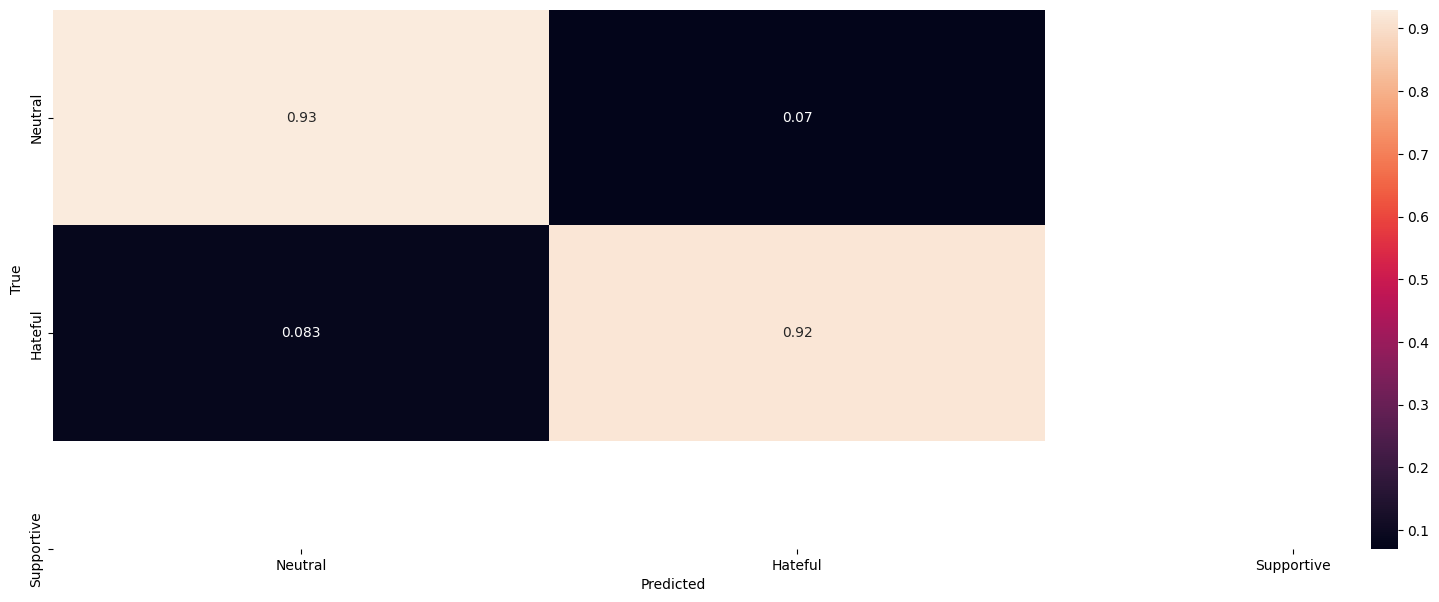

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Neutral", "Hateful", "Supportive"],
    yticklabels=["Neutral", "Hateful", "Supportive"])
plt.xlabel("Predicted")
plt.ylabel("True")

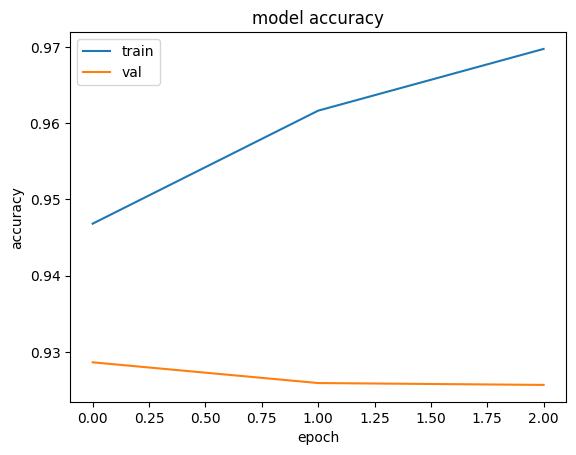

In [ ]:
from matplotlib import pyplot as plt
plt.plot(binary_roberta2_classification_model_history.history['accuracy'])
plt.plot(binary_roberta2_classification_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
combined_preds = []
for i in range(len(predictions1)):
  if predictions1[i] == 0 and binary_predictions2[i] == 1:
    combined_preds.append(binary_predictions2[i])
  else:
    combined_preds.append(predictions1[i])
combined_preds = np.array(combined_preds)

In [ ]:
print(len(predictions1))
print(len(binary_predictions2))

4050
4050


In [ ]:
print(classification_report(roberta_test_labels, combined_preds))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      1343
           1       0.83      0.93      0.88      1329
           2       0.89      0.90      0.90      1378

    accuracy                           0.86      4050
   macro avg       0.86      0.86      0.86      4050
weighted avg       0.86      0.86      0.86      4050



In [ ]:
cm = tf.math.confusion_matrix(roberta_test_labels, combined_preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

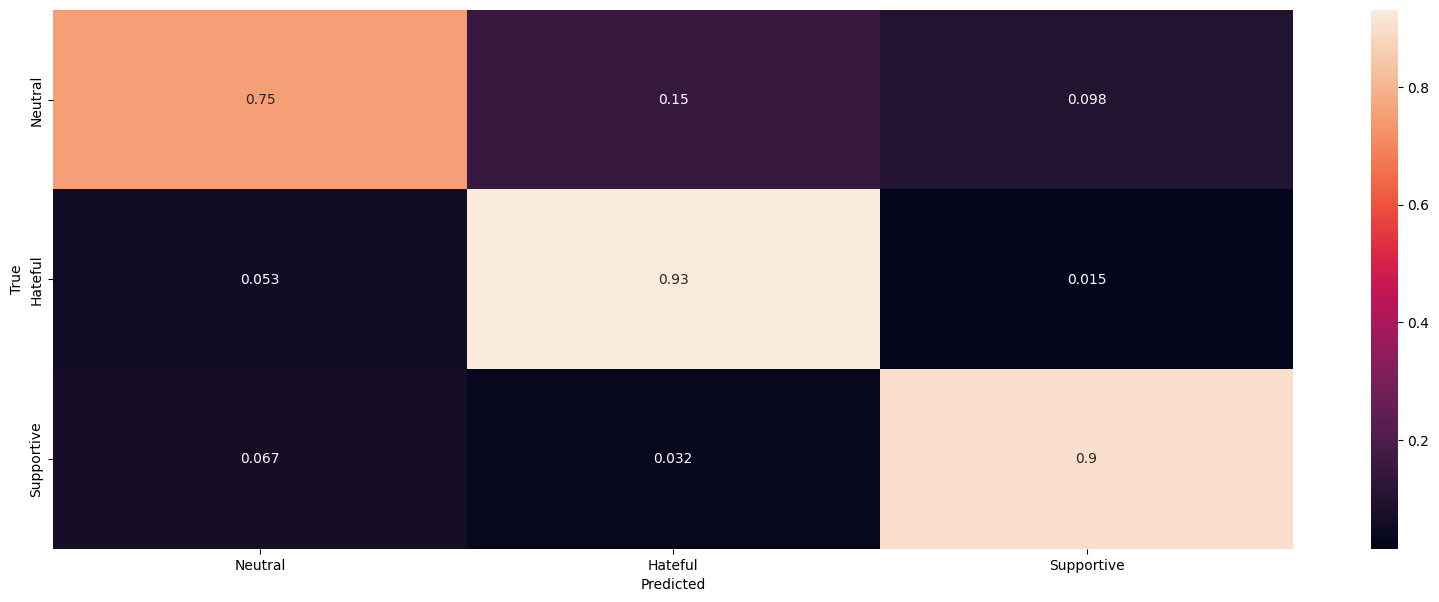

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Neutral", "Hateful", "Supportive"],
    yticklabels=["Neutral", "Hateful", "Supportive"])
plt.xlabel("Predicted")
plt.ylabel("True")

In [ ]:
incorrects = []
for i in range(len(combined_preds)):
  if combined_preds[i] != roberta_test_labels[i]:
    incorrects.append([combined_preds[i],roberta_test_labels[i], test_examples[i]])


In [ ]:
print("Combined Model Mislabeled")
for i in range(10):
  print(f'Text {i}: ' , incorrects[i][2])
  print(f'Predicted Label {i}: ' , incorrects[i][0])
  print(f'True Label {i}: ' , incorrects[i][1])

Text 0:  the fact that you are a virgin is so hot! i just imagine what it would be like to deflower you! 🥵🥵 — fetishizing virgins is weird url
Predicted Label 0:  1
True Label 0:  0
Text 1:  fuck the fuckboys
Predicted Label 1:  1
True Label 1:  0
Text 2:  nice way to go calling it the best upcoming movies when its all about women's ruling the world being the powerful ones while showing the mens bunch of pussies loser and not having the upper hand and not in control small boys will be watching these shitty movies and get brainwashed lets go back 40 years ago or 100 or thousand fuck this new generation
Predicted Label 2:  1
True Label 2:  0
Text 3:   your mum can go and shag herself?
Predicted Label 3:  1
True Label 3:  0
Text 4:  all these tender white "waah i'm so fragile so you must use your free time to explain racism to me because i cannot possibly use google" comments, they're not even directed at me and i don't know how you stand it... it's mad white privilege to go through life 